In [2]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
# from sklearn.decomposition import FastICA
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from sklearn.model_selection import cross_val_score
from itertools import combinations
# from sklearn.preprocessing import normalize
# from sklearn.utils import shuffle
import pickle

from multiprocessing import Pool
plt.style.use('seaborn-whitegrid')
mne.viz.set_3d_backend("notebook")

Using notebook 3d backend.



# GroudTruth

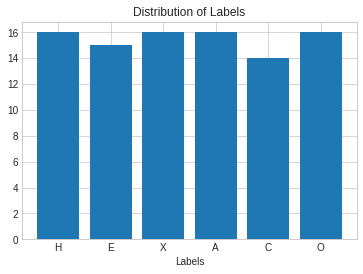

In [3]:
gt = load_groudtruth('./HEXACO.csv')
fig, ax = plt.subplots()
ax.bar(['H','E','X','A','C','O'],[ sum(gt['lh']), sum(gt['le']), sum(gt['lx']), sum(gt['la']), sum(gt['lc']), sum(gt['lo'])  ])
ax.set_title("Distribution of Labels")
ax.set_xlabel("Labels")
# ax.set_ylabel("Distribution of Labels")
plt.show()

# Load DATA

In [4]:
# clear_cache()
try:
    # Load from cache
    EEG_audio = load('EEG_audio')
    EEG_image = load('EEG_image')
    print('Load data from cache')
    if( set(EEG_audio.keys()) != set(EEG_image.keys()) ):
        extra = None
        if(len(EEG_audio.keys()) > len(EEG_image.keys())):
            extra = set(EEG_audio.keys()).difference( set(EEG_image.keys()) )
        else:
            extra = set(EEG_image.keys()).difference( set(EEG_audio.keys()) )
        raise ValueError(f"In equal keys. audio has {len(EEG_audio.keys())} and image has {len(EEG_image.keys())}. The extra key is {extra}")

except FileNotFoundError as e:
    EEG_audio, EEG_image = load_data(path='./data',exclude_list=[11,36])
    # Save to cache
    save(EEG_audio, 'EEG_audio')
    save(EEG_image, 'EEG_image')


Load data from cache


# Generic Head Model

In [5]:
def get_head_model():
    import os.path as op
    from mne.datasets import fetch_fsaverage

    # Download fsaverage files
    fs_dir = fetch_fsaverage('/home/akrarads/mne_data/MNE-fsaverage-data', verbose=True)
    # fs_dir = fetch_fsaverage(verbose=True)
    # subjects_dir = op.dirname(fs_dir)

    # The files live in:
    # subject = 'fsaverage'
    trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
    src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
    bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
    return trans, src, bem

def get_forward(info):

    # trans, src, bem = get_head_model()
    # fwd = mne.make_forward_solution(info, trans=trans, src=src,
    #                             bem=bem, eeg=True, mindist=5.0, n_jobs=1)
    forward_path = os.path.join('../Localize-MI', 'derivatives', 'sourcemodelling', 'sub-07', 'fwd', '%s_fwd.fif' % 'sub-07')
    # print(f"forward_path = {forward_path}")
    fwd = mne.read_forward_solution(forward_path)

    return fwd

def get_raw(df,sfreq, name):
    try:
        # Load from cache
        raw = load(name)
        print('Load data from cache')
    except FileNotFoundError as e:
        raw = dataframe_to_raw(df, sfreq=sfreq)
        #### Preprocess
        # High-pass at 0.1 Hz with  FIR filter; zero phase; Hamming Window; Auto select length and Bandwidth
        raw.filter(l_freq=0.1,h_freq=None,method='fir',phase='zero',fir_window='hamming') # Slow drift
        # Notch Filter at 50,100,150,200 Hz with FIR filter; zero phase; Hamming Window, Bandwidth = 0.1; auto length selection
        raw.notch_filter(freqs=[50,100],method='fir', phase='zero', fir_window='hamming',trans_bandwidth=0.1, filter_length='auto') # Line power
    return raw

In [6]:
try:
    # Load from cache
    fwd = load('fwd')
    print('Load data from cache')
except FileNotFoundError as e:
    with get_raw(df=EEG_image[33],sfreq=250,name='image_33') as raw:
        fwd = get_forward(raw.info)
    # Save to cache
    save(fwd, 'fwd')

Load data from cache


# Processing

In [7]:
verbose = False

In [8]:
# tmin, tmax, baseline = (0.0, 6.0, (0.0, 1.0))
# raw = get_raw(df=EEG_image[33],sfreq=250,name='image_33')
# events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=verbose, uint_cast=False)
# # Convert 421 -> 4
# for row in events:
#     row[2] = int(str(row[2])[0])
# epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, baseline=baseline, verbose=verbose, preload=True)
# epochs.set_eeg_reference(ref_channels='average',projection=True,verbose=verbose)
# cov = mne.compute_covariance(epochs, method='auto', verbose=verbose)
# inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, loose=1, depth=0.1, verbose=verbose)
# snr = 1
# lambda2 = 1. / snr ** 2
# stc = mne.minimum_norm.apply_inverse(epochs.average(), inv, method='eLORETA', lambda2=lambda2, verbose=verbose)
# power,freq = mne.time_frequency.psd_array_welch(stc.data,sfreq=250,n_fft=128, verbose=verbose)


In [9]:
# stc.shape

In [10]:
# stc = stc.data

In [11]:
# scale = 2
# reduc = np.expand_dims(stc[0:569*scale].mean(axis=0), axis=0)
# for i in range(1,36//scale):
#     temp = np.expand_dims(stc[i*569*scale : (i+1)*569*scale].mean(axis=0), axis=0)
#     reduc = np.concatenate([reduc,temp], axis=0)

# print(reduc.shape)

In [12]:
def build_data(p_num, EEG, ids):
    import warnings, sys, os, time
    warnings.filterwarnings("ignore")
    X = None
    Y = None
    E = None
    tmin, tmax, baseline = (0.0, 6.0, (0.0, 1.0))
    t_start, t_stop = 0,0
    for index, id in enumerate(ids):
        print(f"p_no={p_num}|index={index}|id={id}|duration={t_stop-t_start}")
        t_start = time.time()
        raw = get_raw(df=EEG[id],sfreq=250,name=f"image_{id}")
        events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=verbose, uint_cast=False)
        # Convert 421 -> 4
        for row in events:
            row[2] = int(str(row[2])[0])
        epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, baseline=baseline, verbose=verbose, preload=True)
        epochs.set_eeg_reference(ref_channels='average',projection=True,verbose=verbose)
        del(events)
        try:
            cov = load(f'cov_{id}')
            inv = load(f'inv_{id}')
        except FileNotFoundError as e:
            cov = mne.compute_covariance(epochs, method='auto', verbose=verbose)
            inv = mne.minimum_norm.make_inverse_operator(raw.info, fwd, cov, loose=1, depth=0.1, verbose=verbose)
            save(cov,f'cov_{id}')
            save(inv,f'inv_{id}')
        snr = 1
        lambda2 = 1. / snr ** 2
        for inner_index, evoked in enumerate(epochs.iter_evoked()):
            # stc.shape => channels, time
            stc = mne.minimum_norm.apply_inverse(evoked, inv, method='eLORETA', lambda2=lambda2, verbose=verbose).data
            # scale = 2
            # reduc = np.expand_dims(stc[0:569*scale].mean(axis=0), axis=0)
            # for i in range(1,36//scale):
            #     temp = np.expand_dims(stc[i*569*scale : (i+1)*569*scale].mean(axis=0), axis=0)
            #     reduc = np.concatenate([reduc,temp], axis=0)
            # power,freq = mne.time_frequency.psd_array_welch(stc,sfreq=250,n_fft=128, verbose=verbose)
            row = stc
            row = np.expand_dims(row, axis=0)
            # row = 10 * np.log10(row)
            if(type(X) == type(None)): X = row
            else: X = np.concatenate( [X, row ], axis=0 )

            label = gt.loc[id][['lh','le','lx','la','lc','lo']].to_numpy()
            label = np.expand_dims(label, axis=0)
            if(type(Y) == type(None)): Y = label
            else: Y = np.concatenate( [Y, label ], axis=0 )

        if(type(E) == type(None)): E = events
        else: E = np.concatenate( [E, events ], axis=0 )
        t_stop = time.time()

    print(f"{p_num} done| {ids}")
    return np.array(X),np.array(Y),freq,E


In [13]:
try:
    # [33,2,10,12,16]
    t_out = 6000
    pool = Pool()
    ids = np.array(list(EEG_image.keys()))
    p1 = pool.apply_async(build_data, [1,EEG_image,ids[0::1]])
    # p2 = pool.apply_async(build_data, [2,EEG_image,ids[1::2]])
    # p3 = pool.apply_async(build_data, [3,EEG_image,ids[2::3]])
    # p4 = pool.apply_async(build_data, [4,EEG_image,ids[3::6]])
    # p5 = pool.apply_async(build_data, [5,EEG_image,ids[4::6]])
    # p6 = pool.apply_async(build_data, [6,EEG_image,ids[5::6]])
    ans1 = p1.get(timeout=t_out)
    # ans2 = p2.get(timeout=t_out)
    # ans3 = p3.get(timeout=t_out)
    # ans4 = p4.get(timeout=t_out)
    # ans5 = p5.get(timeout=t_out)
    # ans6 = p6.get(timeout=t_out)
    X = np.concatenate([ans1[0]])# , ans2[0]])#, ans3[0]])#, ans4[0] ,ans5[0], ans6[0]])
    Y = np.concatenate([ans1[1]])# , ans2[1]])#, ans3[1]])#, ans4[1] ,ans5[1], ans6[1]])
    E = ans1[3]
    freq = ans1[2]
    print(X.shape, Y.shape, E.shape)
finally:
    print("========= close ========")
    pool.close() 
    pool.terminate()

p_no=1|index=0|id=10|duration=0
========= close ========


KeyboardInterrupt: 

In [ ]:
# save(X,'image_X_full')
# save(Y,'image_Y_full')

In [19]:
X = load('image_X')
Y = load('image_Y')

In [15]:
def get_accuracy(X,y):
    from sklearn.naive_bayes import GaussianNB, MultinomialNB
    from sklearn.model_selection import cross_val_score
    result = []
    traits = ["h","e","x","a","c","o"]
    for index,label in enumerate(traits):
        y = Y[:,index]
        X_copy = X.copy()
        # norm
        for index, row in enumerate(X_copy.T):
            row = (row - row.min()) / (row.max() - row.min())
            X_copy.T[index] = row

        mnb = GaussianNB()
        mnb.fit(X_copy, y)
        acc = sum(mnb.predict(X_copy) == y) / len(y)
        scores = cross_val_score(mnb, X_copy, y)
        result.append([acc,scores.mean(),scores.std()])
        print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
    return result

In [16]:
# get_accuracy((10 * np.log10(X)).mean(axis=2)  ,Y)

In [17]:
from itertools import combinations
band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
filter_list = [[0,4],[4,8],[8,13],[13,30],[30,125]]
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)

result_image = []
best_image = 0
best_image_idx = -1
best_image_comb = None
for r in [1,2,3,4,5]:
    print("="*20,f"Number {r}","="*20)
    for comb in combinations([0,1,2,3,4],r):
        print(" ",band_names[list(comb)])
        selected_x = None
        # print(bands[ list(comb) ])
        for pt in bands[ list(comb) ]:
            # print(pt)
            if(type(selected_x) == type(None)): selected_x = X[:,:,pt].mean(axis=2)
            else:
                selected_x = np.concatenate([selected_x, X[:,:,pt].mean(axis=2)], axis=1)
        print(selected_x.shape)
        # pts = np.concatenate( bands[ list(comb) ] )
        
        # result = np.array(get_accuracy(selected_x ,Y))
        result = np.array(get_accuracy(selected_x  ,Y))
        print(" Averag accuracy:", result[:,0].mean(), "Average Score:", result[:,1].mean(), "Average Variance:", result[:,2].mean())
        result_image.append(result)
        if(result[:,1].mean() > best_image):
            best_image = result[:,1].mean()
            best_image_idx = len(result_image)-1
            best_image_comb = band_names[ list(comb) ]

print(f"Best Score is {best_image} at index {best_image_idx} with combination {best_image_comb}")

NameError: name 'freq' is not defined

In [18]:
result_image = np.array(result_image)
traits = ["h","e","x","a","c","o"]
width =.35

fig, ax = plt.subplots(figsize=(12,8))

ax.bar(np.arange(6)      ,result_image[best_image_idx,:,0] * 100, yerr=result_image[best_image_idx,:,2] * 100, width=width, label='image', ecolor='black', capsize=10)
# ax.bar(np.arange(6)+width,result_audio[best_audio_idx,:,0] * 100, yerr=result_image[best_audio_idx,:,2] * 100, width=width, label='audio', ecolor='black', capsize=10)

ax.set_xlabel('Traits')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of each trait prediction')
ax.set_xticks(np.arange(6) + width / 2)
ax.set_xticklabels(traits)
ax.legend()

plt.show()

NameError: name 'result_image' is not defined